Conciliación carrier Internacional

*En este notebook se ha desarrollado una herramienta para la concialicación de la propuesta de carrier internacional. Además, da información en ese mes de análisis de los beneficios/pérdidas que ha supuesto el carrier por país.

*Consideraciones:
    .Se nutre de:
        1. Crudo de OCS cuando b_tipollamada es RoamingVoiceMOC,RoamingVoiceMTC e InternationalVoice.
        2. Propuesta de Telefónica.
        3. AZ de Telefónica.
   
   .Categoriza OCS con el AZ de telefónica.

------------------------------------------------------------------------------------------

Este proceso realiza dos subprocesos para poder categorizar los eventos, aunque ambos utilizan la misma lógica. La lógica es:

    DictF = {}

    for k in called:
    k=str(k)
    i=0
    okei = False
    for i in range(len(k)):
        cc = left(k,len(k)-i)
        if cc in DictCode:
            DictF[k]= cc
            okei = True 
            break
    if not okei: 
        print("Error {}".format(k))
---------------------------------------------------------------------------------------------        
*Por un lado se realiza cuando b_tipollamada es InternationalVoice y RoamingVoiceMOC. Y por otro, RoamingVoiceMTC. En el primer punto se busca la máxima coincidencia por b_numerollamado con el AREA Code de TESA y en el segundo punto se utiliza el Country Code Location. Una vez realizado los dos subprocesos se realiza un join y vuelven a participar de un proceso común.
        

# Librerías

In [4]:
import sys
sys.path.append('..')

from modulodirectorio import*
from Utils import*
from bbdd_conect import*


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file
from bokeh.models import FactorRange
from bokeh.models import Title
from pivottablejs import pivot_ui
from IPython.display import HTML
output_notebook()
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Loading BokehJS ...

C:\Users\aelordi\AppData\Local\Temp\ipykernel_23068\915374976.py:22: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Inputs:

In [2]:
#inputs automaticos:

DictOp = pd.read_excel(get_path('dict_az_country'))
DictTar = pd.read_excel(get_path('dict_ocs_country'))


In [5]:
#Inputs manuales:


mes_revision = 202306
query = query_database('query_carrier_internacional', mes=mes_revision) 
RawCDR = query


path = get_path('az_carrier')
filename = input("Ingresar el nombre del archivo del AZ nuevo: ") + ".csv" # 20230630_transf
fullpath = os.path.join(path, filename)
    
    
AZ1= pd.read_csv(fullpath)

path = get_path('prop_dashboard')
filename = input("Ingresar el nombre del archivo de la propuesta pasada: ") + ".csv" # 202305.AV CARRIER MAYO 2023_transf
fullpath = os.path.join(path, filename)
    
    
Pro= pd.read_csv(fullpath)


 202306 query_carrier_internacional > Conexión exitosa


c:\Users\aelordi\OneDrive - Avatel Telecom\Documentos interes\Local Anaconda\proyecto_anaconda\Notebook\Carrier internacional\..\bbdd_conect.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection, params =params)


 202306 query_carrier_internacional > Tiempo de ejecución consulta: 2.93 minutos
 query_carrier_internacional > Conexión finalizada


In [20]:
AZ2 = AZ1

Historico carrier:

202203.AV CARRIER MARZO 2022
marzo
20220501

abril
AZ mal formato/20220501 utilizo el de mayo
202204.AV CARRIER ABRIL 2022

mayo
20220501
202205.AV CARRIER MAYO 2022

junio
20220601
202206.AV CARRIER JUNIO 2022

julio
20220701
202207.AV CARRIER julio 2022

agosto
20220801
202208.AV CARRIER agosto 2022

septiembre
20220930
202209.AV CARRIER septiembre 2022

octubre
20221101
202210.AV CARRIER OCTUBRE 2022_VERSIÓN 2_actualizada

noviembre
20221201
AV CARRIER NOVIEMBRE 2022

diciembre
23122022
AV CARRIER DICIEMBRE 2022

23122022
AV CARRIER DICIEMBRE 2022
diciembre

01022023
AV CARRIER ENERO 2023
enero

20230401
202303.AV CARRIER MARZO 2023

Normalización de datos:

In [21]:
Pro = Pro.rename(columns={"DESCRIPCION": "Destination"})
#Realizamos un merge para generar una columna nueva que permita traducir la columna Destcountry en un pais, esto es la categorización del tarificador.
RawCDR=pd.merge(RawCDR, DictTar,  how='left', left_on=['b_paisdestino'], right_on = ['DestCountry'])
#Unificador de AZ, la lógica consiste en coger la última fecha de aplicación por operador
#realizamos un concat de todos los AZ recibidos en un mes
AZ = pd.concat([AZ1, AZ2], ignore_index=True)
AZ = AZ[['Rate', 'Effective Date', 'Area Code', 'Destination']]
#Ordenamos el dataframe por fecha de aplicación
AZ = AZ.sort_values('Effective Date',ascending=False)
#Agrupamos por MSISDN y cogemos el primer valor, para relacionar el MSISDN con su estado más actual respecto al operador.
AZ = AZ.groupby('Area Code').first().reset_index()
AZRate = AZ[['Rate', 'Area Code', 'Destination']]
AZRateM = AZ[['Area Code']]
AZRateM = AZRateM['Area Code'].tolist()
AZRateM = [int(a) for a in AZRateM]
AZRateM = [str(a) for a in AZRateM]
AZRate['Area Code'] = AZRateM
AZRate= AZRate[['Rate','Area Code', 'Destination']]
#Modificamos a string en pandas
AZDest=AZRate[['Rate','Area Code', 'Destination']]#Incluimos el pais al que pertenece el operador
Pro = Pro.merge(DictOp, on="Destination", how='left')
#Renombramos el valor de Origzone en llamada internacional para normalizar los datos
RawCDR['b_bandacosteorigen'] = RawCDR['b_bandacosteorigen'].replace(['NACIONAL'],['Zona 1'])
Code = AZ['Area Code'].astype(str)
RawCDR['duracion'] = RawCDR['b_duracion']/60
RawCDR['Fecha']  = pd.to_datetime(RawCDR['b_fechainicio'])
RawCDR['Fecha'] = RawCDR['Fecha'].dt.date

C:\Users\aelordi\AppData\Local\Temp\ipykernel_23068\1433298865.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AZRate['Area Code'] = AZRateM


Proceso común a ambos:

In [22]:
#Elemento intrínseco a los dos procesos

DictCode = {}
for i in Code:
    DictCode[i]= '' 
    

Proceso 1: InternacionalVoice and RoamingVoiceMOC

In [23]:
RawCDRM = RawCDR[(RawCDR['b_tipollamada'] == "InternationalVoice") | (RawCDR['b_tipollamada'] == "RoamingVoiceMOC")] #Me quito RoamingVoiceMTC

RawCDRM.drop(RawCDRM.loc[RawCDRM['b_paisdestino']=='ESPAÑA'].index, inplace=True)

called = RawCDRM['b_numerollamado'].fillna(0)
called = RawCDRM['b_numerollamado'].tolist()

#quitar duplicados en una lista
called = list(set(called))
called = [int(a) for a in called] 


#Coincidencias InternationalVoice y RoamingVoiceMOC
DictF = {}

for k in called:
    k=str(k)
    i=0
    okei = False
    for i in range(len(k)):
        cc = left(k,len(k)-i)
        if cc in DictCode:
            DictF[k]= cc
            okei = True 
            break
    if not okei: 
        print("Error {}".format(k))
              
#Convertimos el diccionario a pandas       
NumB_Code = pd.DataFrame.from_dict(DictF, orient='index').reset_index()
NumB_Code.columns = ['b_numerollamado', 'AreaCode']
NumB_Code = [str(a) for a in NumB_Code]
NumB_Code = pd.DataFrame.from_dict(DictF, orient='index').reset_index()
NumB_Code.columns = ['b_numerollamado', 'Area Code']

#Unimos con un merge para relacionar MSISDN con los operadores
NumB_Code = NumB_Code.merge(AZRate, on="Area Code", how='left')
NumBfix = RawCDRM['b_numerollamado'].tolist() #lo queremos con duplicados

#Para poder  hacer el merge más adelante los datos tienen que pasar por los mismo estados antes de llegar al formato string
NumBfix = [int(a) for a in NumBfix]
NumBfix = [str(a) for a in NumBfix]
RawCDRMFinal = RawCDRM[['b_fechainicio','b_uniquerecordidentifier','b_numerollamante','b_tipollamada','Fecha','duracion', 'b_numerollamado','Pais','b_coste','b_volumen','b_bandacosteorigen','b_bandacostedestino','b_paisorigen','b_paisdestino','b_offername_1']]

#añado la columna NumB sin ser float
RawCDRMFinal['b_numerollamado'] = NumBfix

#Relacionamos la volumetría del tarificador con el dataframe con los operadores
RawCDRMFinal = RawCDRMFinal.merge(NumB_Code, on="b_numerollamado", how='left')

#Generamos la columna con el coste del evento
RawCDRMFinal['PriceCall']= RawCDRMFinal['duracion'] * RawCDRMFinal['Rate']

#Traduzco el nombre del operador para incluir mi categorización de pais.
RawCDRMFinal = RawCDRMFinal.merge(DictOp, on="Destination", how='left')

C:\Users\aelordi\AppData\Local\Temp\ipykernel_23068\1264498513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RawCDRM.drop(RawCDRM.loc[RawCDRM['b_paisdestino']=='ESPAÑA'].index, inplace=True)
C:\Users\aelordi\AppData\Local\Temp\ipykernel_23068\1264498513.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RawCDRMFinal['b_numerollamado'] = NumBfix


Proceso 2: RoamingVoiceMTC

In [24]:
#RoamingVoiceMTC
RawCDRMTC = RawCDR[(RawCDR['b_tipollamada'] == "RoamingVoiceMTC")]
RawCDRMTC.drop(RawCDRMTC.loc[RawCDRMTC['b_paisdestino']=='ESPAÑA'].index, inplace=True)

cclocation=RawCDRMTC['cclocation']
cclocation = [int(a) for a in cclocation]

#Coincidencias entre MTC y AreaCode del AZ
#Aquí creo un diccionario y recorro cclocation por el diccionario de Códigos quitandole dígitos hasta encontrar la coincidencia de mayor longitud
DictFMTC = {}

for k in cclocation:
    k=str(k)
    i=0
    okei = False
    for i in range(len(k)):
        cc = left(k,len(k)-i)
        if cc in DictCode:
            DictFMTC[k]= cc
            okei = True 
            break
    if not okei: 
        print("Error {}".format(k))
        
        
#Convierto el diccionario en un dataframe
CC_Code = pd.DataFrame.from_dict(DictFMTC, orient='index').reset_index()
CC_Code.columns = ['b_numerollamado', 'Area Code']

#Convierto las variables a string
CC_Code = [str(a) for a in CC_Code]
CC_Code = pd.DataFrame.from_dict(DictFMTC, orient='index').reset_index()
CC_Code.columns = ['b_numerollamado', 'Area Code']

#Lo cruzo con el AZ para sacar el operador
CC_Code = CC_Code.merge(AZRate, on="Area Code", how='left')
CCfix = [int(a) for a in cclocation]
CCfix = [str(a) for a in cclocation]
RawCDRMTCFinal = RawCDRMTC[['b_fechainicio','b_uniquerecordidentifier','b_numerollamante','b_tipollamada','Fecha','duracion', 'b_numerollamado','Pais','b_coste','b_volumen','b_bandacosteorigen','b_bandacostedestino','b_paisorigen','b_paisdestino','b_offername_1']]

#Añadimos la columna NumB sin ser float
RawCDRMTCFinal['b_numerollamado'] = CCfix
RawCDRMTCFinal = RawCDRMTCFinal.merge(CC_Code, on="b_numerollamado", how='left')

#Genero una columna nueva de coste total por evento
RawCDRMTCFinal['PriceCall']= RawCDRMTCFinal['duracion'] * RawCDRMTCFinal['Rate']
RawCDRMTCFinal = RawCDRMTCFinal.merge(DictOp, on="Destination", how='left')

C:\Users\aelordi\AppData\Local\Temp\ipykernel_23068\3560066386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RawCDRMTC.drop(RawCDRMTC.loc[RawCDRMTC['b_paisdestino']=='ESPAÑA'].index, inplace=True)
C:\Users\aelordi\AppData\Local\Temp\ipykernel_23068\3560066386.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RawCDRMTCFinal['b_numerollamado'] = CCfix


Concatenamos los dos dataframe generados en el proceso 1 y 2

In [25]:
ResumenFinal = pd.concat([RawCDRMTCFinal, RawCDRMFinal], ignore_index=True)
#Tradudimos la columna de los operadores para identificar el pais bajo la categorización que hacemos bajo este proceso y no, con la del tarificador..

ResumenFinal = ResumenFinal[ResumenFinal['duracion'] != 0]

In [27]:
#Agrupamos por la categorización creada
DisCountryprocessed = ResumenFinal.groupby(by='Paisprocessed').agg({'b_coste': lambda x: sum(x),
                                                                    'duracion': 'sum',
                                                                    'PriceCall': 'sum',
                                                                    'b_uniquerecordidentifier':'nunique'}).reset_index()

DisOpeprocessed = ResumenFinal.groupby(by='Destination').agg({'b_coste': lambda x: sum(x),
                                                              'duracion': 'sum',
                                                              'PriceCall': 'sum',
                                                              'b_uniquerecordidentifier':'nunique'}).reset_index()

#Agrupamos el dataframe de la propuesta facturada
PropOp = Pro.groupby(by='Destination').sum().reset_index()
PropOp = PropOp[['Destination','DURACION','IMPORTES','LLAMADAS']]
Pro = Pro.groupby(by='Paisprocessed').sum().reset_index()
Pro = Pro[['Paisprocessed','DURACION','IMPORTES','LLAMADAS']]

#Hacemos un join por pais para incluir la volumetría por pais y el precio
DisCountryprocessed = DisCountryprocessed.merge(Pro, on="Paisprocessed", how='outer')
DisCountryprocessed = DisCountryprocessed.fillna(0)

DisOpeprocessed = DisOpeprocessed.merge(PropOp, on="Destination", how='outer')

#Creamos las columnas con el porcentaje de error por minuto e importe, para ver si la discrepancias está en volumetría o en coste.
DisCountryprocessed['DifPMIN']= (abs((DisCountryprocessed['duracion'] - DisCountryprocessed['DURACION'])/DisCountryprocessed['DURACION'])*100).round(2)
DisCountryprocessed['DifPIMPORTE']= (abs((DisCountryprocessed['PriceCall'] - DisCountryprocessed['IMPORTES'])/DisCountryprocessed['IMPORTES'])*100).round(2)

#Una vez hemos agrupado para sacer el beneficio por pais restamos el importe agregado de lo que le repercutimos al cliente menos loq ue nos repercuten a nuestra compañia por las conexiones.
DisCountryprocessed['DifBen']= DisCountryprocessed['IMPORTES'] - DisCountryprocessed['PriceCall']

#Ordenamos por los paises que tienen más volumetría, porque ordenar por discrepancia no tiene sentido porque los paises con muy poca volumetría te van a salir un error muy alto.
DisCountryprocessed = DisCountryprocessed.sort_values('duracion',ascending=False)

#calculamos la diferencia de minutos
DisCountryprocessed['DifMIN']= abs((DisCountryprocessed['duracion'] - DisCountryprocessed['DURACION'])).round(2)
DisOpeprocessed['DifMIN']= abs((DisOpeprocessed['duracion'] - DisOpeprocessed['DURACION'])).round(2)

#Diferncia de importe
DisOpeprocessed['DifBen']= abs((DisOpeprocessed['IMPORTES'] - DisOpeprocessed['PriceCall'])).round(2)

#Precio unitario llamada
DisOpeprocessed['Importe unitario TESA']= abs((DisOpeprocessed['IMPORTES']/DisOpeprocessed['DURACION'])).round(4)
DisOpeprocessed['Importe unitario AZ']= abs((DisOpeprocessed['PriceCall']/DisOpeprocessed['duracion'])).round(4)

#Beneficio
DisCountryprocessed['Beneficio/perdidas']= (DisCountryprocessed['b_coste'] - DisCountryprocessed['PriceCall']).round(2)
DisOpeprocessed['Beneficio/perdidas']= (DisOpeprocessed['b_coste'] - DisOpeprocessed['PriceCall']).round(2)

#DisOpeprocessed[['minutos OCS','b_coste','Mediacion coste TESA','minutos TESA','Importe Facturado TESA']] =  DisOpeprocessed[['minutos OCS','b_coste','Mediacion coste TESA','minutos TESA','Importe Facturado TESA']].round(2)
#DisCountryprocessed[['minutos OCS','b_coste','Mediacion coste TESA','minutos TESA','Importe Facturado TESA','Diferencia Precios']] =  DisCountryprocessed[['minutos OCS','b_coste','Mediacion coste TESA','minutos TESA','Importe Facturado TESA','Diferencia Precios']].round(2)

C:\Users\aelordi\AppData\Local\Temp\ipykernel_23068\1896675639.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  PropOp = Pro.groupby(by='Destination').sum().reset_index()
C:\Users\aelordi\AppData\Local\Temp\ipykernel_23068\1896675639.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Pro = Pro.groupby(by='Paisprocessed').sum().reset_index()


KeyError: "['minutos OCS', 'Mediacion coste TESA', 'minutos TESA', 'Importe Facturado TESA'] not in index"

# Output .xlsx:

In [11]:
ResumenFinal.to_csv ('Detalle Carrier internacional procesado.csv', sep=',', index=False)
#DisCountryprocessed.to_excel('Conciliación carrier internacional procesado.xlsx', sheet_name='sheet1', index=True)

Consolidación carrier con la categorización creada

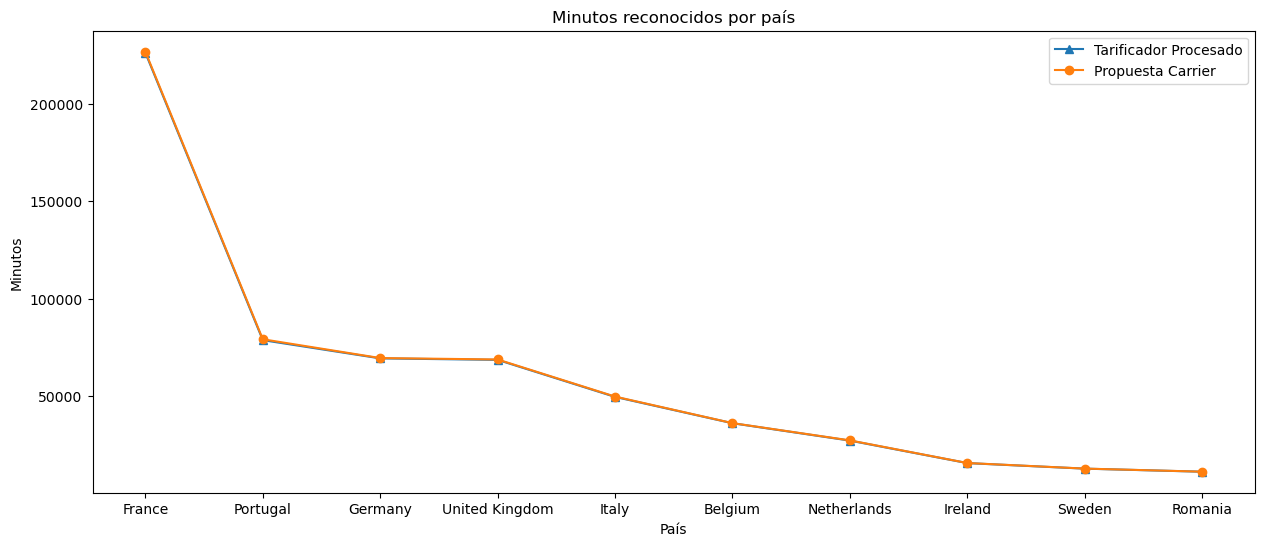

In [12]:
Graf1 = DisCountryprocessed.head(10)

fig, ax = plt.subplots()
plt.title('Minutos reconocidos por país')
ax.plot(Graf1['Paisprocessed'], Graf1['duracion'], marker = '^', label = 'Tarificador Procesado')
ax.plot(Graf1['Paisprocessed'], Graf1['DURACION'], marker = 'o', label = 'Propuesta Carrier')

fig.set_size_inches(15, 6)

ax.set_xlabel("País")
ax.set_ylabel("Minutos")

ax.legend(loc = 'upper right')

plt.show()

In [13]:
p = figure(x_range=FactorRange(*DisCountryprocessed['Paisprocessed']),width=900, height=300 )

p.line(x=DisCountryprocessed['Paisprocessed'], y=DisCountryprocessed['DifMIN'], color="blue", line_width=2)

tooltips = [
            ('Pais','@Paisprocessed{%F}'),
            ('Duracion OCS', '@duracion'),
            ('Duracion Propuesta', '@DURACION'),
            
             ]

p.add_tools(HoverTool(tooltips=tooltips))

p.add_layout(Title(text="País", align="center"), "below")
p.add_layout(Title(text="Minutos", align="center"), "left")

show(p)

In [15]:
p.line(x=DisOpeprocessed['Destination'], y=DisOpeprocessed['DifBen'], color="blue", line_width=2)

tooltips = [
            ('Pais','@Destination{%F}'),
            ('Duracion OCS', '@duracion'),
            ('Duracion Propuesta', '@DURACION'),
            
             ]

p.add_tools(HoverTool(tooltips=tooltips))

p.add_layout(Title(text="País", align="center"), "below")
p.add_layout(Title(text="Diferencia importe €", align="center"), "left")

show(p)

<BarContainer object of 10 artists>

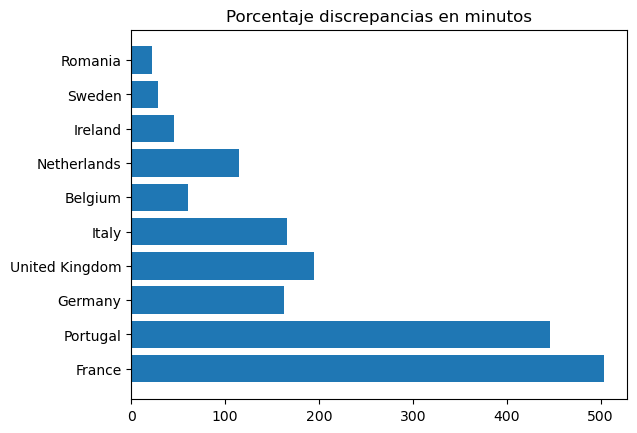

In [15]:
plt.title('Porcentaje discrepancias en minutos')
plt.barh(Graf1['Paisprocessed'], Graf1['DifMIN'])

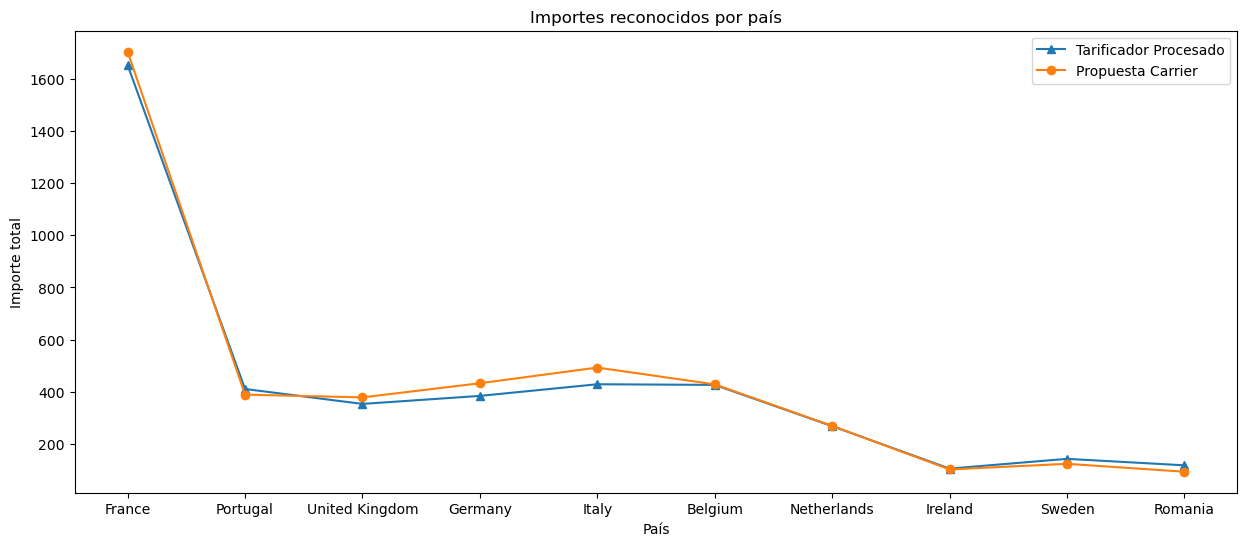

In [17]:
Graf1 = DisCountryprocessed.head(10)

fig, ax = plt.subplots()
plt.title('Importes reconocidos por país')
ax.plot(Graf1['Paisprocessed'], Graf1['PriceCall'], marker = '^', label = 'Tarificador Procesado')
ax.plot(Graf1['Paisprocessed'], Graf1['IMPORTES'], marker = 'o', label = 'Propuesta Carrier')

fig.set_size_inches(15, 6)

ax.set_xlabel("País")
ax.set_ylabel("Importe total")

ax.legend(loc = 'upper right')

plt.show()

In [17]:
p = figure(x_range=FactorRange(*DisCountryprocessed['Paisprocessed']),width=800, height=250 )

#p = figure(x_range=DisCountryprocessed['Paisprocessed'], width=800, height=300)
#p.line(DisCountryprocessed['Paisprocessed'],DisCountryprocessed['duracion'], color='blue', alpha=0.5)
#p.line(DisCountryprocessed['Paisprocessed'],DisCountryprocessed['DURACION'], color='orange', alpha=0.5)



# Add the HoverTool to the figure
p.line(x=DisCountryprocessed['Paisprocessed'], y=DisCountryprocessed['DifBen'], color="red", line_width=2)
#p.line(x=DisCountryprocessed['Paisprocessed'], y=DisCountryprocessed['IMPORTES'], color="blue", line_width=2)

tooltips = [
            ('Pais','@Paisprocessed{%F}'),
            ('Duracion OCS', '@duracion'),
            ('Duracion Propuesta', '@DURACION'),
            
             ]

p.add_tools(HoverTool(tooltips=tooltips))

p.add_layout(Title(text="País", align="center"), "below")
p.add_layout(Title(text="Importe", align="center"), "left")

show(p)

<BarContainer object of 10 artists>

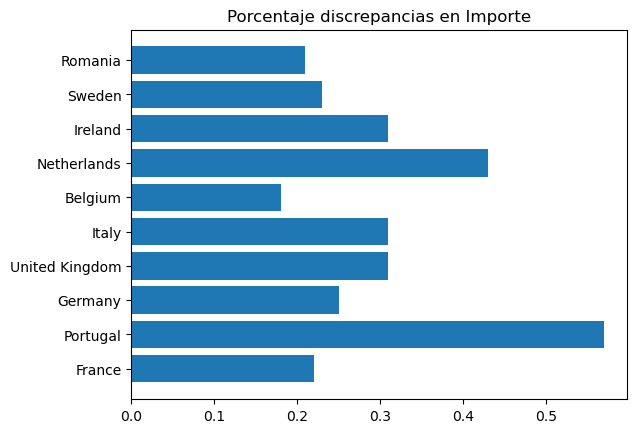

In [18]:
Graf1 = DisCountryprocessed.head(10)
plt.title('Porcentaje discrepancias en Importe')
plt.barh(Graf1['Paisprocessed'], Graf1['DifPIMPORTE'])

In [29]:
filepath1=get_path('analisis_carrier_output')

In [30]:
DisCountryprocessed = DisCountryprocessed.rename(columns={"Paisprocessed": "Pais Destino Reclasificado",
                                                          "duracion": "minutos OCS",
                                                          "DURACION": "minutos TESA",
                                                          "PriceCall": "Mediacion coste TESA",
                                                          "IMPORTES": "Importe Facturado TESA",
                                                          "DifPIMPORTE": "Diferencia Porcentual Precios",
                                                          "DifPMIN": "Diferencia Porcentual Minutos",
                                                          "DifMIN": "Diferencia Minutos",
                                                          "DifBen": "Diferencia Precios",
                                                          "b_uniquerecordidentifier": "Nº llamadas OCS" })


DisOpeprocessed = DisOpeprocessed.rename(columns={"Paisprocessed": "Pais Destino Reclasificado",
                                                          "duracion": "minutos OCS",
                                                          "DURACION": "minutos TESA",
                                                          "PriceCall": "Mediacion coste TESA",
                                                          "IMPORTES": "Importe Facturado TESA",
                                                          "DifPIMPORTE": "Diferencia Porcentual Precios",
                                                          "DifPMIN": "Diferencia Porcentual Minutos",
                                                          "DifMIN": "Diferencia Minutos",
                                                          "DifBen": "Diferencia Precios",
                                                          "b_uniquerecordidentifier": "Nº llamadas OCS" })



#DisOpeprocessed[['minutos OCS','b_coste','Mediacion coste TESA','minutos TESA','Importe Facturado TESA']] =  DisOpeprocessed[['minutos OCS','b_coste','Mediacion coste TESA','minutos TESA','Importe Facturado TESA']].round(2)
#DisCountryprocessed[['minutos OCS','b_coste','Mediacion coste TESA','minutos TESA','Importe Facturado TESA','Diferencia Precios']] =  DisCountryprocessed[['minutos OCS','b_coste','Mediacion coste TESA','minutos TESA','Importe Facturado TESA','Diferencia Precios']].round(2)


pivot_ui(DisCountryprocessed,
    outfile_path=filepath1/"Conciliación Carrier paises.html",
    rendererName= "Table",
    rowOrder= "value_z_to_a", 
    colOrder= "value_z_to_a",
    rendererOptions= {
        "c3": { "data": {"colors": {
            "Liberal": '#dc3912', "Conservative": '#3366cc', "NDP": '#ff9900',
            "Green":'#109618', 'Bloc Quebecois': '#A05EB5'
        }}}
    }
)

# Definir los colores para el degradado
color1 = "#A05EB5"  # Color inicial
color2 = "#2A0A29"  # Color final

# Ruta de la imagen a añadir
ruta_imagen = get_path('image_html')

# Abrir el archivo HTML generado
with open(filepath1/"Conciliación Carrier paises.html", "r") as file:
    html_content = file.read()

# Modificar el código HTML para agregar el degradado de color al fondo y la imagen en el margen superior
modified_html_content = html_content.replace(
    "<head>",
    f"<head><style>body {{ background: linear-gradient(to bottom, {color1}, {color2}); }}</style>"
    f"<style>#image-container {{ position: absolute; top: 10px; left: 80%; transform: translateX(-50%); width: 25px; height: 25px; opacity: 0.7; }}</style>"
    f"</head><body><div id='image-container'><img src='{ruta_imagen}'></div>"
)

# Escribir el contenido modificado en el archivo HTMLs
with open(filepath1/"Conciliación Carrier paises.html", "w") as file:
    file.write(modified_html_content)


In [30]:
pivot_ui(DisOpeprocessed,
    outfile_path=filepath1/"Conciliación Carrier operadores.html",
    rendererName= "Table",
    rowOrder= "value_z_to_a", 
    colOrder= "value_z_to_a",
    rendererOptions= {
        "c3": { "data": {"colors": {
            "Liberal": '#dc3912', "Conservative": '#3366cc', "NDP": '#ff9900',
            "Green":'#109618', 'Bloc Quebecois': '#990099'
        }}}
    }
)


# Ruta de la imagen a añadir
ruta_imagen = get_path('image_html')

# Abrir el archivo HTML generado
with open(filepath1/"Conciliación Carrier operadores.html", "r") as file:
    html_content = file.read()

# Modificar el código HTML para agregar el degradado de color al fondo y la imagen en el margen superior
modified_html_content = html_content.replace(
    "<head>",
    f"<head><style>body {{ background: linear-gradient(to bottom, {color1}, {color2}); }}</style>"
    f"<style>#image-container {{ position: absolute; top: 10px; left: 80%; transform: translateX(-50%); width: 25px; height: 25px; opacity: 0.7; }}</style>"
    f"</head><body><div id='image-container'><img src='{ruta_imagen}'></div>"
)

# Escribir el contenido modificado en el archivo HTML
with open(filepath1/"Conciliación Carrier operadores.html", "w") as file:
    file.write(modified_html_content)

In [31]:
print(DisCountryprocessed['Mediacion coste TESA'].sum())
print(DisCountryprocessed['Importe Facturado TESA'].sum())

11161.645945
12548.05912797


Como se intuye que la conciliación es un proceso que cierra el mes en carrier internacional, al ejecutar este proceso se entiende que los datos son los más actuales, por tanto, se ejecuta el notebook de Dashboard Historico Carrier Internacional.ipynb para actualizar los 3 CSV que se utilizan para visualizar el carrier.

In [23]:
%run Dashboard Historico Carrier Internacional.ipynb

Exception: File `'Dashboard.py'` not found.